In [75]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

shapefile_path = "land_parcels.shp"
gdf = gpd.read_file(shapefile_path)

# reproject to EPSG:3347
gdf = gdf.to_crs(epsg=3347)

# compute area in square kilometers
gdf["area_km2"] = gdf.geometry.area / 1e6

# filter out polygons below area_threshold
area_threshold = 1
init_count = gdf.shape[0]
gdf = gdf[gdf["area_km2"] >= area_threshold]
filtered_count = init_count - gdf.shape[0]

# summary of the dataset
num_polygons = gdf.shape[0]
min_area = gdf["area_km2"].min()
avg_area = gdf["area_km2"].mean()
max_area = gdf["area_km2"].max()
carbon_store_range = (gdf["carbon_sto"].min(), gdf["carbon_sto"].max())
cost_range = (gdf["cost"].min(), gdf["cost"].max())

summary = f"""
Polygons after filtering: {num_polygons}
Polygons removed: {filtered_count}

Area (km²):
    Min: {min_area}
    Avg: {avg_area}
    Max: {max_area}

Carbon Store Range: {carbon_store_range}
Cost Range: {cost_range}
"""
print(summary)


Polygons after filtering: 100
Polygons removed: 0

Area (km²):
    Min: 37.378247236911356
    Avg: 80.54003288468243
    Max: 132.0955428630866

Carbon Store Range: (10.036534572755878, 99.8608996768998)
Cost Range: (524.9516816211429, 4982.434015347925)



In [76]:
# compute adjacency matrix
num_parcels = len(gdf)
adjacency_matrix = np.zeros((num_parcels, num_parcels), dtype=int)
for i in range(num_parcels):
    for j in range(i + 1, num_parcels):
        if gdf.geometry.iloc[i].touches(gdf.geometry.iloc[j]):
            adjacency_matrix[i, j] = 1
            adjacency_matrix[j, i] = 1

In [77]:
# define the problem
problem = LpProblem(name="land_parcels_optimization", sense=LpMaximize)

# define decision variables
parcels = list(gdf.index)

# x[p] is a binary variable (1 if selected, 0 otherwise).
x = {p: LpVariable(name=f"parcel_{p}", cat='Binary') for p in parcels}

In [78]:
# objective function
problem += lpSum(gdf.loc[p, "carbon_sto"] * x[p] for p in parcels)

# constraint #1 (Budget):
budget_limit = 0.5 * gdf["cost"].sum()
problem += lpSum(gdf.loc[p, "cost"] * x[p] for p in parcels) <= budget_limit

# constraint #2 (No adjacency):
for i in range(num_parcels):
    for j in range(num_parcels):
        if adjacency_matrix[i, j] == 1:
            problem += x[parcels[i]] + x[parcels[j]] <= 1

# constraint #3 (Area):
min_selected_area = 0.25 * gdf["area_km2"].sum()
problem += lpSum(gdf.loc[p, "area_km2"] * x[p] for p in parcels) >= min_selected_area

problem.solve()

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/d4/6r524yqx4lsbn99gww8xth600000gn/T/6521beb279c845d389be3b9ec0516544-pulp.lp
 -o /var/folders/d4/6r524yqx4lsbn99gww8xth600000gn/T/6521beb279c845d389be3b9ec0516544-pulp.sol
Reading problem data from '/var/folders/d4/6r524yqx4lsbn99gww8xth600000gn/T/6521beb279c845d389be3b9ec0516544-pulp.lp'...
686 rows, 100 columns, 1568 non-zeros
100 integer variables, all of which are binary
891 lines were read
GLPK Integer Optimizer 5.0
686 rows, 100 columns, 1568 non-zeros
100 integer variables, all of which are binary
Preprocessing...
686 rows, 100 columns, 1568 non-zeros
100 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.982e+03  ratio =  4.982e+03
GM: min|aij| =  4.850e-01  max|aij| =  2.062e+00  ratio =  4.252e+00
EQ: min|aij| =  2.352e-01  max|aij| =  1.000e+00  ratio =  4.252e+00
2N: min|aij| =  1.327e-01  max|aij| =  1.102e+00  ratio =  8.303e+00
Cons

1

Selected parcels: [0, 2, 6, 9, 14, 20, 22, 26, 29, 34, 40, 46, 49, 52, 54, 60, 67, 69, 73, 81, 85, 87, 93, 99]
Total Carbon Store: 1857.4268690033723
Total Cost: 67793.17435924022
Total Selected Area (km²): 2043.8368503235408


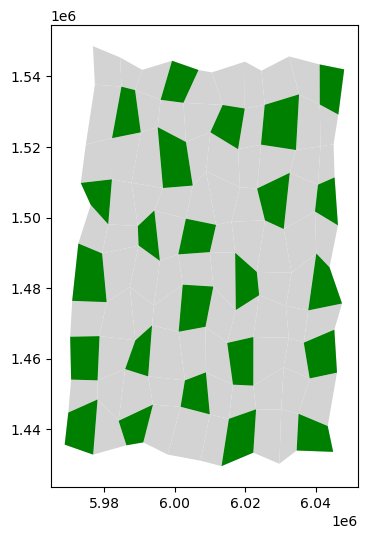

In [79]:
selected_parcels = [p for p in parcels if x[p].varValue == 1]
total_carbon_store = sum(gdf.loc[p, "carbon_sto"] for p in selected_parcels)
total_cost = sum(gdf.loc[p, "cost"] for p in selected_parcels)
selected_area = sum(gdf.loc[p, "area_km2"] for p in selected_parcels)

print("Selected parcels:", selected_parcels)
print("Total Carbon Store:", total_carbon_store)
print("Total Cost:", total_cost)
print("Total Selected Area (km²):", selected_area)

# visualization
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, color='lightgray')
# plot selected parcels in green
gdf.loc[selected_parcels].plot(ax=ax, color='green')
plt.show()

## **Report** ##

### **1. Approach and Methodology**

An optimization problem was solved using the MILP framework with PuLP as the underlying library. The dataset comprises polygons of land parcels, each possessing attributes of **carbon storage**, **cost**, and **area**. The said methodology follows the steps outlined below.

1. **Data Preprocessing:**

   - A shapefile containing the parcels was read in through `geopandas`. Furthermore, the polygons were transformed into a  projection: **EPSG:3347**.

   - Extracted polygons were filtered to remove outlier values in terms of area size.

2. **Defining the Optimization Model:**

   - **Decision Variables:** Each parcel was represented as a binary decision variable $d_p$ (1 if selected, 0 otherwise).

   - **Objective Function:** The target of the model was to maximize the total **carbon storage** of the parcels of land selected.

   - **Constraints:**

     - **Budget Constraint:** Set a limit on the total cost of the selected parcels: 50% of the **total available budget**.

     - **Adjacency Constraint:** Prevents the selection of two adjacent parcels at the same time.

     - **Minimum Area Constraint:** Selected parcels must not be smaller than 25% of the total estimated area.

3. **Solution:**

   - This step runs the solver using GLPK.

- The analyzed outcomes were particularly presented with green highlighting the selected areas.

### **2. Challenges**

The most important challenge was learning how **to effectively use PuLP** and how to define the constraints.

### **3. Key Results**

- **Selected Parcels:** `[0, 2, 6, 9, 14, 20, 22, 26, 29, 34, 40, 46, 49, 52, 54, 60, 67, 69, 73, 81, 85, 87, 93, 99]`

- **Total Carbon Storage:** `1857.43`

- **Total Cost:** `67,793.17`

- **Total Selected Area:** `2043.84 km²`

All chosen parcels were able to satisfy all constraints defined and maximize carbon storage.

### **4. Analysis**
The optimization succeeded in prioritizing high carbon parcels without breaching any constraint. The total cost, 67,793.17 was below the 50% budget ceiling. The adjacency constraint was met, and selected parcels (green) were optimally distributed across the area to avoid adjacent selections. The selected area of 2043.84 km² already surpassed the 25% area requirement.



